In [1]:
import pandas as pd
import numpy as np
import Utils

dataset_name = 'PorCuEX2008'
#dataset_name = 'EarthChem'

commodity = 'AU' #gold
#commodity = 'CU' #copper

#Utils.set_parameter('region_of_interest_polygon_file', '../data/polygon_north_america.csv')
Utils.set_parameter('region_of_interest_polygon_file', '../data/polygon_south_america.csv')

In [2]:
if dataset_name == 'PorCuEX2008':
    #get the deposits inside the polygon
    data = pd.read_csv("../data/PorCuEX2008.csv")
    polygon_points = Utils.get_region_of_interest_polygon().values.flatten()
    points_mask = Utils.check_points_within_polygon(data.LongitudeDecimal, data.LatitudeDecimal, polygon_points)
    
    data = data[points_mask]

    ages = np.round(data.AgeMY)
    ages = np.nan_to_num(ages)
    lons = data.LongitudeDecimal
    lats = data.LatitudeDecimal
    indices = list(range(len(ages)))
    print('selected data from dataset PorCuEX2008')

reading ../data/polygon_south_america.csv
selected data from dataset PorCuEX2008


In [3]:
if dataset_name == 'EarthChem':
    import extract_earth_chem
    earth_chem_file = 'EarthChem_all.csv'
    polygon_points = Utils.get_region_of_interest_polygon().values.flatten()
    data = extract_earth_chem.query(earth_chem_file, commodity, polygon_points)
    data.drop_duplicates(inplace=True) 
    
    data = data.groupby(['LATITUDE', 'LONGITUDE']).agg({'AGE':['max'], commodity:['mean']})
    data.columns=['AGE',commodity]
    #data = data.iloc[::100,:]
    data.reset_index(inplace=True)
    #display(data)
    
    ages = np.round(data.AGE)
    ages = np.nan_to_num(ages)
    lons = data.LONGITUDE
    lats = data.LATITUDE
    indices = list(range(len(ages)))
    print('selected data from dataset EarthChem')

/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:305: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:329: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


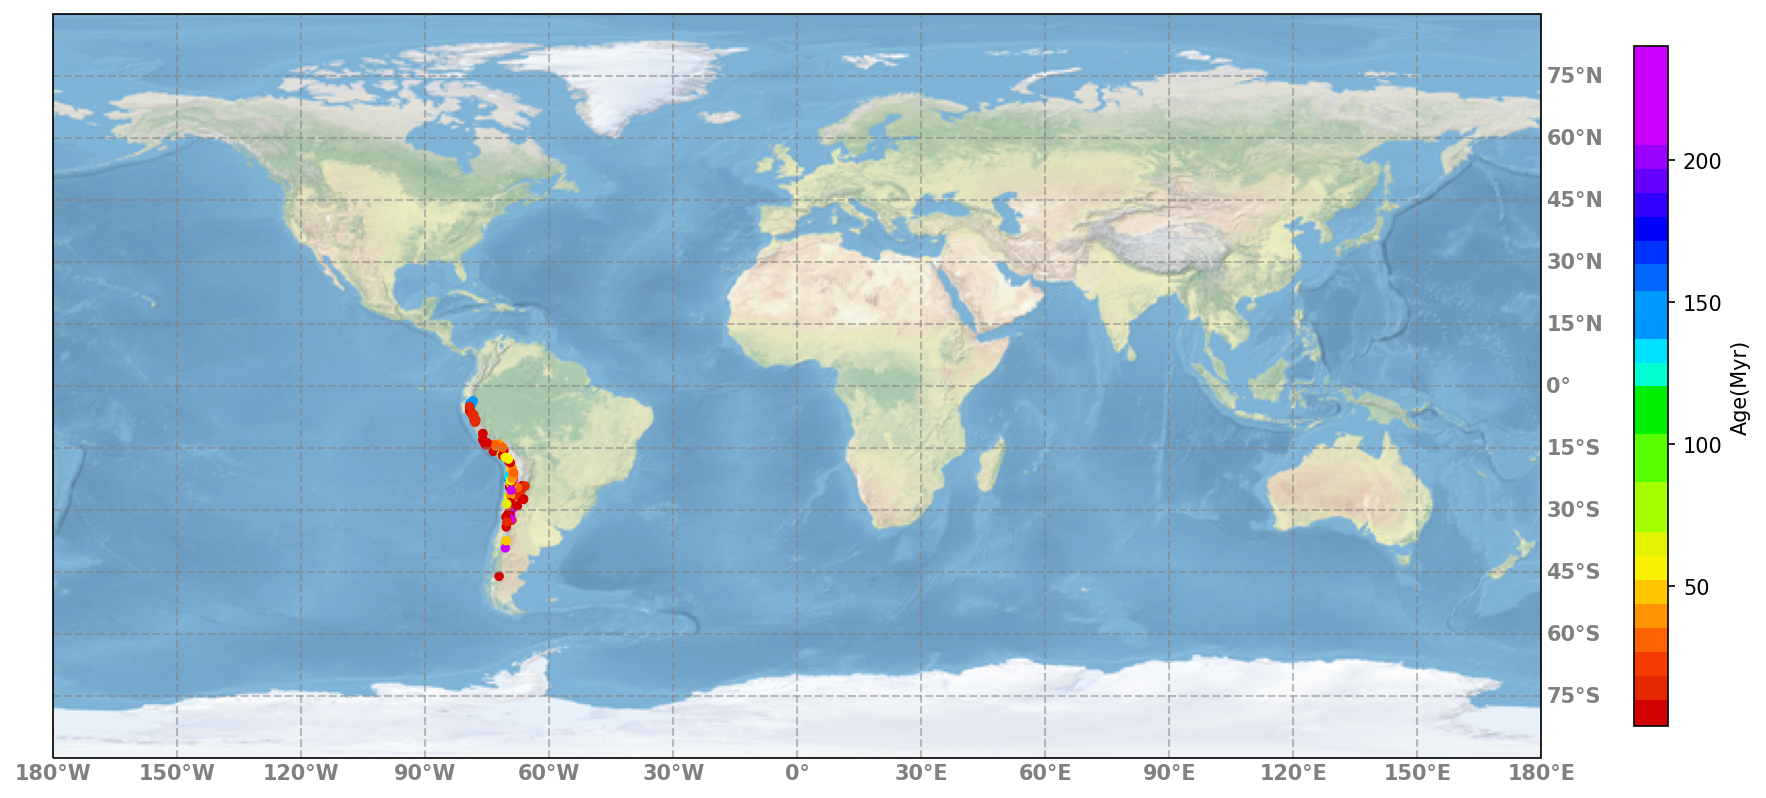

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd

#plot the map
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.ylocator = mticker.FixedLocator([-90, -75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}

ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
#ax.set_extent([-85, -29, -55, 15])
agegrid_cmap = Utils.get_age_grid_color_map_from_cpt('agegrid.cpt')
cb = ax.scatter(lons, lats, 50, marker='.',c=ages, 
                vmin=1, vmax=240, cmap=agegrid_cmap)

fig.colorbar(cb, shrink=0.5, label='Age(Myr)')
plt.show()

In [5]:
#save five columns csv
import pygplates
from parameters import parameters

static_polygons = pygplates.FeatureCollection(parameters['static_polygons_file'])
rotation_model = pygplates.RotationModel(Utils.get_files(parameters['rotation_files']))
plate_ids = Utils.get_plate_id(lons.tolist(), 
                               lats.tolist(), 
                               static_polygons, 
                               rotation_model)

data_of_five_columns = np.c_[indices, lons, lats, ages, plate_ids]
data_of_five_columns = data_of_five_columns[~np.isnan(data_of_five_columns).any(axis=1)].tolist()

df_data = pd.DataFrame(data_of_five_columns, columns=['index', 'lon','lat','age','plate_id'])
df_data = df_data.astype({'index': int, "plate_id": int, "age":int}) 

#save positive deposits
df_data.to_csv(f'positive_deposits_{dataset_name}.csv', index=False, float_format='%.2f')

#save negative deposits
time = Utils.get_parameter('time')
start_time = time['start'] 
end_time = time['end']
df_data.age = np.random.randint(start_time+1, end_time, size=len(df_data.age))
df_data.to_csv(f'negative_deposits_{dataset_name}.csv', index=False, float_format='%.2f')

#save candidates
deposit_candidates = Utils.get_deposit_candidates()
deposit_candidates.to_csv(f'deposit_candidates_{dataset_name}.csv', index_label = 'index')

print('saved coregistration input files')

saved coregistration input files


In [6]:
#save coordinates with rgb
rgb=[]
for age in ages:
    if age > 240:
        age = 240
    if age < 0:
        age = 0
    age = age/240
    color = agegrid_cmap(age)
    tmp = f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'.upper()
    rgb.append(tmp)
#print(rgb)

data_rgb = np.c_[lons, lats, rgb]
#print(data_rgb)
df_data = pd.DataFrame(data_rgb, columns=['lon','lat','rgb'])
df_data = df_data.astype({'lon': float, "lat": float}) 
df_data.to_csv(f'deposits_rgb_{dataset_name}.csv', index=False, float_format='%.2f')
print('saved deposit color file')

saved deposit color file
